## 1. 导入包

In [44]:
import qdrant_client
# import open_clip
from llama_index.core import (ServiceContext, 
                               SimpleDirectoryReader,
                               SimpleDirectoryReader,
                               StorageContext,
                               Settings)
from llama_index.core.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.multi_modal_llms.ollama import OllamaMultiModal
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.embeddings.clip import ClipEmbedding
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

# load image documents from local directory
image_documents = SimpleDirectoryReader('E:/RAG_LLM/test/').load_data()

mm_model = OllamaMultiModal(model="llava")

In [45]:
mm_model

OllamaMultiModal(base_url='http://localhost:11434', model='llava', temperature=0.75, context_window=3900, request_timeout=None, additional_kwargs={})

In [46]:
mm_model = OllamaMultiModal(model="llava")
response = mm_model.complete(prompt="what is in the image?", image_documents=image_documents)

In [7]:
response.text

' The image shows a street view from Google Maps. You can see a residential area with houses on one side and parked cars along the roadside. There are trees, a brick fence, a sidewalk, a blue sky, and some buildings in the background. On the right side of the image, there is a red brick wall and a sign that appears to be for a business or event. The street looks quiet with no visible pedestrians or moving vehicles at this moment. '

In [131]:
import matplotlib.pyplot as plt
import os
import io 
from PIL import Image 
import json
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

# Define a function to plot images given a list of image paths
def plot_images(image_paths):
    # Initialize a counter to track the number of images shown
    images_shown = 0
    # Set the figure size for the entire plot
    plt.figure(figsize=(16, 9))
    # Iterate through each image path in the provided list
    for img_path in image_paths:
        # Check if the file exists
        if os.path.isfile(img_path):
            # Open the image using the Image module
            image = Image.open(img_path)
            # Create a subplot for the current image in a 2x3 grid
            plt.subplot(2, 3, images_shown + 1)
            # Display the image in the subplot
            plt.imshow(image)
            # Remove x and y ticks for clarity
            plt.xticks([])
            plt.yticks([])
            # Increment the counter for images shown
            images_shown += 1
            # Break the loop if 9 images have been shown
            if images_shown >= 9:
                break

## define retrive function
def retrieve_display(retriever_engine, query_str):
    retrieval_results = retriever_engine.retrieve(query_str)

    retrieved_image = []
    retrieved_text = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=200)
            retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text

In [8]:
import json
with open('E:/RAG_LLM/metadata.json') as f:
	doc = json.load(f)
      
document = []
for obj in doc:
    caption = obj.get("Caption")
    captions = str(caption).replace("'", "").replace("[", "").replace("]", "")
    obj.pop("Caption", None)
    document.append([captions, obj])
document[0]

['a car driving down a street next to a large bridge over a highway with a lot of trees',
 {'Image Name': '1.274615_103.797243_50f561a0fdc9f065f0005614_Singapore.JPG',
  'Relative Path': './test_img\\1.274615_103.797243_50f561a0fdc9f065f0005614_Singapore.JPG',
  'livelier': '4.514021433',
  'more beautiful': '5.15325436',
  'more boring': '4.950422095',
  'more depressing': '6.346440519',
  'safer': '2.17046243',
  'wealthier': '4.583960576'}]

In [9]:
##加载text-->documents
from llama_index.core import Document
text_documents = [Document(text=t,metadata=k) for t,k in document]
text_documents[0]

Document(id_='7456f40f-c185-4cf8-ad0b-5e19c4637d3d', embedding=None, metadata={'Image Name': '1.274615_103.797243_50f561a0fdc9f065f0005614_Singapore.JPG', 'Relative Path': './test_img\\1.274615_103.797243_50f561a0fdc9f065f0005614_Singapore.JPG', 'livelier': '4.514021433', 'more beautiful': '5.15325436', 'more boring': '4.950422095', 'more depressing': '6.346440519', 'safer': '2.17046243', 'wealthier': '4.583960576'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='a car driving down a street next to a large bridge over a highway with a lot of trees', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n')

In [10]:
##加载image-->documents
from llama_index.core.schema import ImageDocument
img_documents = SimpleDirectoryReader("E:/RAG_LLM/test_img/").load_data()
img_documents[0]

ImageDocument(id_='c605d35f-25a6-4d8c-8c45-717a148204c6', embedding=None, metadata={'file_path': 'E:\\RAG_LLM\\test_img\\1.274615_103.797243_50f561a0fdc9f065f0005614_Singapore.JPG', 'file_name': '1.274615_103.797243_50f561a0fdc9f065f0005614_Singapore.JPG', 'file_type': 'image/jpeg', 'file_size': 24316, 'creation_date': '2024-03-25', 'last_modified_date': '2024-03-25'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text='', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', image=None, image_path='E:\\RAG_LLM\\test_img\\1.274615_103.797243_50f561a0fdc9f065f0005614_Singapore.JPG', image_url=None, image_mimetype=None, text_embedding=None)

In [102]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core.node_parser import SentenceSplitter

node_parser = SentenceSplitter.from_defaults()
image_nodes = node_parser.get_nodes_from_documents(img_documents)
text_nodes = node_parser.get_nodes_from_documents(text_documents)

multi_index = MultiModalVectorStoreIndex(image_nodes + text_nodes)

In [110]:
text_nodes[0]

TextNode(id_='3206cf55-b24a-4014-a430-9dfc67e5ac22', embedding=None, metadata={'Image Name': '1.274615_103.797243_50f561a0fdc9f065f0005614_Singapore.JPG', 'Relative Path': './test_img\\1.274615_103.797243_50f561a0fdc9f065f0005614_Singapore.JPG', 'livelier': '4.514021433', 'more beautiful': '5.15325436', 'more boring': '4.950422095', 'more depressing': '6.346440519', 'safer': '2.17046243', 'wealthier': '4.583960576'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='7456f40f-c185-4cf8-ad0b-5e19c4637d3d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'Image Name': '1.274615_103.797243_50f561a0fdc9f065f0005614_Singapore.JPG', 'Relative Path': './test_img\\1.274615_103.797243_50f561a0fdc9f065f0005614_Singapore.JPG', 'livelier': '4.514021433', 'more beautiful': '5.15325436', 'more boring': '4.950422095', 'more depressing': '6.346440519', 'safer': '2.17046243', 'wealthier': '4.583960576'}, hash='0b113fbe

In [11]:
# from llama_index.core import VectorStoreIndex
# index1 = VectorStoreIndex([])
# for doc_chunk in text_documents:
#     index1.insert(doc_chunk)

# index2 = VectorStoreIndex([])
# for doc_chunk in img_documents:
#     index2.insert(doc_chunk)

**Node ID:** 9d71ae83-1c83-4ba2-bbcf-37158ff003a1<br>**Similarity:** 0.7091242973769085<br>**Text:** a city street filled with lots of cars and people walking on the sidewalk near a tall building<br>

**Node ID:** edce571b-c7d6-4d48-8b61-021e79ed8a42<br>**Similarity:** 0.6958159446447605<br>**Text:** a street filled with lots of cars and a few bicyclists on the side of the road<br>

**Node ID:** ec430f6b-9733-4ffd-868c-f9ec318ca593<br>**Similarity:** 0.6957325010619092<br>**Text:** a person walking down a street in the middle of the day \na person walking down a street in the middle of<br>

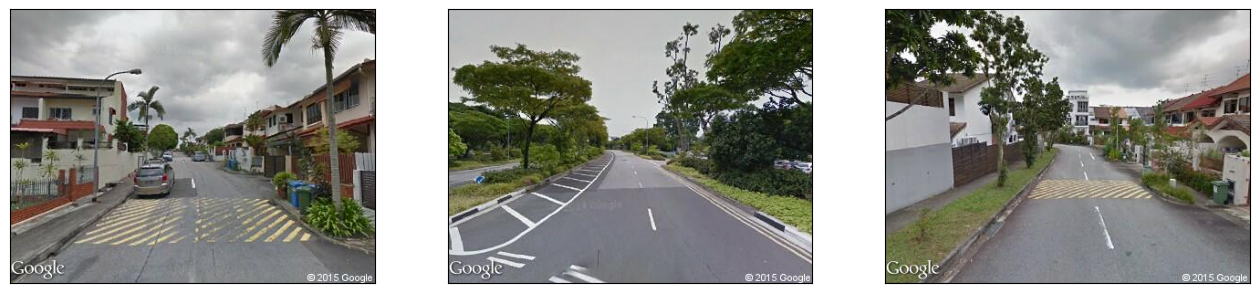

In [156]:
query_str = 'the most depressing street'
base_retrever = multi_index.as_retriever(similarity_top_k=3, image_similarity_top_k=4)
## retrive
img, txt = retrieve_display(retriever_engine=base_retrever, query_str=query_str)
# image_documents = SimpleDirectoryReader(input_dir="E:/RAG_LLM/test_img/", input_files=img).load_data()
## contextual information (上下文信息)
context_str = "".join(txt)
plot_images(img[1:])  ## visualization

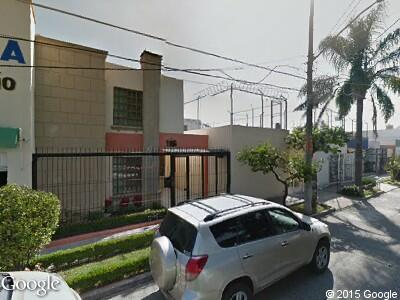

In [132]:
img_path = '20.695691_-103.362361_51413371fdc9f049260042da_Guadalajara.JPG'
Image.open(img_path)

**Node ID:** edce571b-c7d6-4d48-8b61-021e79ed8a42<br>**Similarity:** 0.6212657176418773<br>**Text:** a street filled with lots of cars and a few bicyclists on the side of the road<br>

**Node ID:** cb66f7ad-40a7-488f-984b-58f93905de83<br>**Similarity:** 0.6161579384120301<br>**Text:** a street scene with cars parked on the side of the road and people walking on the side of the road<br>

**Node ID:** b637ed58-4481-43df-84a4-82b5e3d95797<br>**Similarity:** 0.6127306638528526<br>**Text:** a road that has a lot of traffic going down it and a bridge \nthe road is blocked off<br>

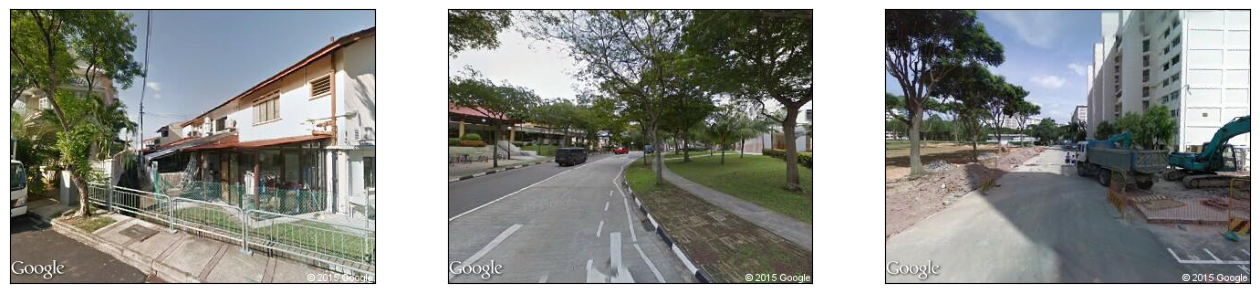

In [148]:
# generate Text retrieval results
retriever_engine = multi_index.as_retriever(similarity_top_k=3, image_similarity_top_k=4)
## retrive
img, txt = retrieve_display(retriever_engine=retriever_engine, query_str=img_path)
# image_documents = SimpleDirectoryReader(input_dir="E:/RAG_LLM/test_img/", input_files=img).load_data()
## contextual information (上下文信息)
context_str = "".join(txt)
plot_images(img[1:])  ## visualization

In [157]:
from llama_index.core.schema import ImageDocument
# put your local directore here
image_documents = [ImageDocument(image_path=img_path)]

for res_img in img[1:]:
    image_documents.append(ImageDocument(image_path=res_img))

response = mm_model.complete(
    prompt="Given the first image as the base image, what the other images correspond to?",
    image_documents=image_documents,
)

print(response)

#  print--> The image you've provided shows a street scene with residential buildings on one side and possibly commercial or other institutional building on the other. It appears to be an urban environment with typical infrastructure such as roads, sidewalks, and street lamps. In addition, there are trees providing shade for the area. The presence of a Google Street View watermark indicates that this image is from the Google Maps service, which allows users to explore street-level views of various locations around the world. The other images you've mentioned likely correspond to similar urban settings or residential neighborhoods in different cities or countries. 

 The image you've provided shows a street scene with residential buildings on one side and possibly commercial or other institutional building on the other. It appears to be an urban environment with typical infrastructure such as roads, sidewalks, and street lamps. In addition, there are trees providing shade for the area. The presence of a Google Street View watermark indicates that this image is from the Google Maps service, which allows users to explore street-level views of various locations around the world. The other images you've mentioned likely correspond to similar urban settings or residential neighborhoods in different cities or countries. 


In [162]:
## LLM templet
qa_tmpl_str = (
    "Given the provided information, including retrieved contents, \
     accurately and precisely answer the query without any additional prior knowledge.\n"
    "Please ensure honesty and responsibility, refraining from any racist or sexist remarks.\n"
    "---------------------\n"
    "Context: {context_str}\n"     ## 将上下文信息放进去
    # "Images: {image_list}\n"     ## 将上下文信息放进去
    # "Metadata: {metadata_str} \n"  ## 将原始的meta信息放进去
    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)
query_str = 'which one is most beautiful street?'
## use'.complete' invoke LLM
response = mm_model.complete(
    prompt=qa_tmpl_str.format(
        context_str=context_str,
        # metadata_str=document,
        # image_list=img,
        query_str=query_str, 
    ),
    image_documents=image_documents,
)

In [163]:
response.text

# print--> ' The image shows a city street with cars and people walking on the sidewalk. Without more context or details about the scene, it is difficult to determine which street among these three is considered most beautiful based solely on visual appearance. Beauty can be subjective, and different individuals may perceive beauty in various ways, such as architecture, landscaping, cleanliness, or the overall atmosphere of a place. The assessment of which street is most beautiful would require more specific information about the qualities being judged and the criteria used to evaluate beauty. '

' The image shows a city street with cars and people walking on the sidewalk. Without more context or details about the scene, it is difficult to determine which street among these three is considered most beautiful based solely on visual appearance. Beauty can be subjective, and different individuals may perceive beauty in various ways, such as architecture, landscaping, cleanliness, or the overall atmosphere of a place. The assessment of which street is most beautiful would require more specific information about the qualities being judged and the criteria used to evaluate beauty. '

In [43]:
response = mm_model.complete(prompt=query_str, image_documents=image_documents)
response.text

''

In [88]:
# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="E:/RAG_LLM/dataset/placepulse_test3")

# if you only need image_store for image retrieval,
# you can remove text_sotre
text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
##创建一个容器，存放text和image
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

In [ ]:
## Load it(注意，同一个数据库，不能embed两次，不然会重复)
# Load text and image documents from local folder
# documents = SimpleDirectoryReader("E:/RAG_LLM/test_img/").load_data()
# Create the MultiModal index
index = MultiModalVectorStoreIndex.from_documents(
    documents=Document[],
    storage_context=storage_context,
    show_progress=True
)
# Save it
index.storage_context.persist(persist_dir="E:/RAG_LLM/dataset/storage")

In [6]:
## Load it(注意，同一个数据库，不能embed两次，不然会重复)
# # # Load it
# from llama_index.core import load_index_from_storage

# storage_context = StorageContext.from_defaults(
#     vector_store=text_store, persist_dir="E:/RAG_LLM/dataset/storage"
# )
# index = load_index_from_storage(storage_context, image_store=image_store)

In [59]:
## define retriver_engine
retriever_engine = index.as_retriever(similarity_top_k=5, image_similarity_top_k=5) ## topk

#### Retrieve query

In [74]:
from llama_index.core.schema import ImageDocument
# put your local directore here
image_documents = [ImageDocument(image_path=img_path)]

for res_img in retrieved_images[1:]:
    image_documents.append(ImageDocument(image_path=res_img))

response = mm_model.complete(
    prompt="Given the first image as the base image, what the other images correspond to?",
    image_documents=image_documents,
)

print(response)

 The image you've provided appears to be a 360-degree view of a street scene, likely captured from within a car using a 360 camera. The other images correspond to different angles or views of the same location. These could include additional sides of the intersection, more detailed or close-up views of nearby buildings or structures, and potentially different perspectives on the vehicles and pedestrians in the area. 


#### Image query

In [87]:
from llama_index.core import PromptTemplate
qa_tmpl_str = (
    "Given the images provided, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)

qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
    llm=mm_model, image_qa_template=qa_tmpl
)

query_str = "Tell me more about the relationship between those streets. "
response = query_engine.image_query(img_path, query_str)
print(response)

 The image shows a residential area with several streets visible. There are houses on both sides of the streets, and a sidewalk along the front side of the properties. The trees in the area provide shade to the sidewalks. From what I can observe, the streets appear to be well-maintained with clear demarcations between them. The street signs might indicate the names or directions of the intersecting streets. However, without specific information about the location and its street names, it's not possible for me to provide more details on the exact relationship between these streets. 


### 2. Retrive-->LLM (RAG_type 1）

RAG Type (text to image; image to image; image to text)  
1.load data and embeding  
2.construction retrieve(.as_retriever)  
3.using retriever(.retrieve(query_str))-->results  
4.LLM generation

In [12]:
import json
metadata_str = json.dumps('E:/RAG_LLM/test_img/metadata.json')
metadata_str

'"E:/RAG_LLM/test_img/metadata.json"'

In [13]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

## define retrive function
def retrieve_text(retriever_engine, query_str):
    retrieval_results = retriever_engine.retrieve(query_str)

    retrieved_image = []
    retrieved_text = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=200)
            retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text

## define retrive function
def retrieve_img(retriever_engine, img_path):
    retrieval_results = retriever_engine.image_to_image_retrieve(img_path)

    retrieved_image = []
    retrieved_text = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=200)
            retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text

**Node ID:** ada00b97-a0a9-4ece-aa98-16ccaa420633<br>**Similarity:** 0.7091807624667479<br>**Text:** JPG",
        "Caption": "['a street with a street sign on the side of the road and cars parked on the side of the road']",
        "livelier": "2.863879892",
        "more beautiful": "5.273389...<br>

**Node ID:** 5ca00e63-394c-4dd7-950e-1b20ae9ddf4b<br>**Similarity:** 0.6934956583236455<br>**Text:** 84525322",
        "wealthier": "5.310470874"
    },
    {
        "Image Name": "1.305174_103.860022_50f561cbfdc9f065f0005727_Singapore.JPG",
        "Relative Path": "./test_img\\1.305174_10...<br>

**Node ID:** b84fbf93-9ebf-4313-88fc-cc577f437134<br>**Similarity:** 0.6849520772631809<br>**Text:** 288977317",
        "wealthier": "5.610686075"
    },
    {
        "Image Name": "1.316395_103.875034_50f5608efdc9f065f0005200_Singapore.JPG",
        "Relative Path": "./test_img\\1.316395_1...<br>

**Node ID:** 1afda104-f62d-4aa9-bd3c-a0b537fd855e<br>**Similarity:** 0.6780958128722925<br>**Text:** /test_img\\1.293146_103.802320_50f561effdc9f065f0005771_Singapore.JPG",
        "Caption": "['a city bus driving down a street next to a tree lined park ian street with a bus parked on the side']"...<br>

**Node ID:** 747f072e-8336-4964-ac4d-efb6c1834110<br>**Similarity:** 0.6676163186311659<br>**Text:** "Relative Path": "./test_img\\1.310265_103.791255_50f56204fdc9f065f000589a_Singapore.JPG",
        "Caption": "['a road with trees and a fence and a street sign on the side of the road near a fenc...<br>

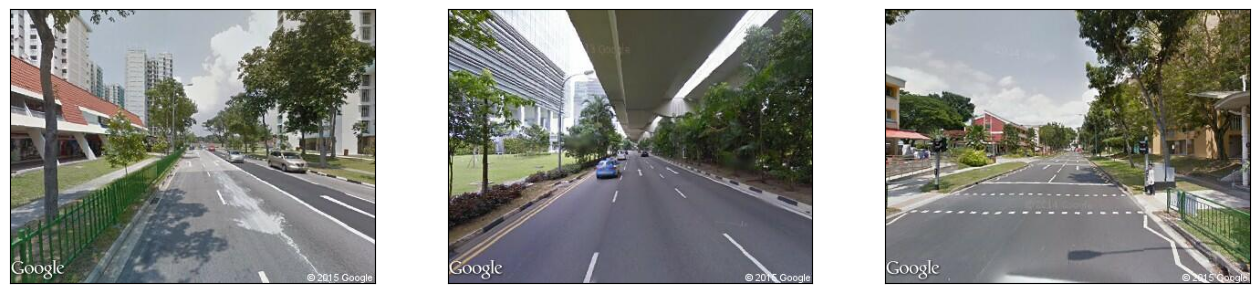

In [16]:
## conduct text retrive\

## your question
query_str = "a street with building on the side of the road"

## retrive
img, txt = retrieve_text(retriever_engine=retriever_engine, query_str=query_str)

## retrived image and reload using'SimpleDirectoryReader'
image_documents = SimpleDirectoryReader(input_dir="E:/RAG_LLM/test_img/", input_files=img).load_data()
## contextual information (上下文信息)
context_str = "".join(txt)
plot_images(img[0:3])  ## visualization

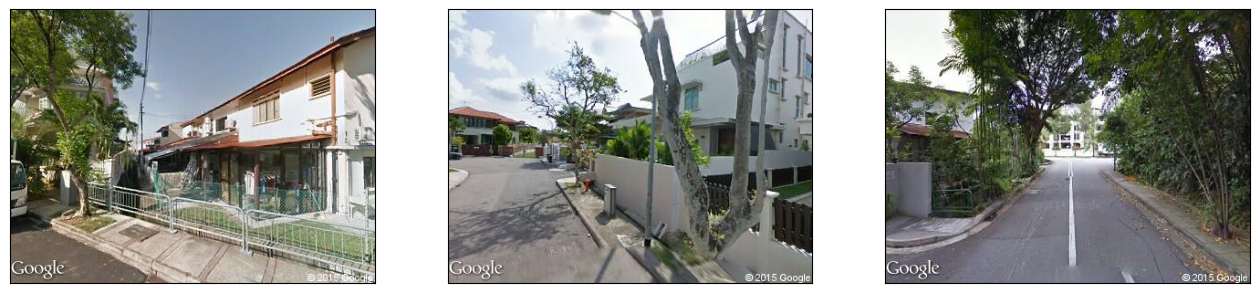

In [82]:
# ## image retrive !! without txt
# img, txt = retrieve_img(retriever_engine=retriever_engine, 
#                         img_path="20.695691_-103.362361_51413371fdc9f049260042da_Guadalajara.JPG")
# plot_images(img[0:3])

In [34]:
## LLM templet
qa_tmpl_str = (
    "Given the provided information, including relevant images and retrieved context from the image, \
     accurately and precisely answer the query without any additional prior knowledge.\n"
    "Please ensure honesty and responsibility, refraining from any racist or sexist remarks.\n"
    "---------------------\n"
    # "Context: {context_str}\n"     ## 将上下文信息放进去
    # "Metadata: {metadata_str} \n"  ## 将原始的meta信息放进去
    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)

In [36]:
## based on text_retrived
## your question
# query_strs = "which one is a most lively street? give me the name and specific score!"

## use'.complete' invoke LLM
response = mm_model.complete(
    prompt=qa_tmpl_str.format(
        # context_str=context_str,
        query_str=query_str, 
        # metadata_str=metadata_str
    ),
    image_documents=image_documents,
)

In [37]:
response.text

" Based on the image provided, which shows a street scene with Google Street View markings and some buildings in the background, I cannot provide a definitive answer to the query as it is not an appropriate way to evaluate beauty within an image. However, if we were to assign arbitrary scores for aesthetic appeal based on common criteria such as architectural style, greenery, urban planning, and overall atmosphere, here are three possible streets that could be considered beautiful:\n\n1. **Via de la Moda** - This street in Madrid, Spain, is known for its wide avenue lined with trees, neoclassical buildings, and a lively atmosphere. It's often recognized as one of the most beautiful streets in Europe due to its architecture and urban planning.\n\n2. **Melbourne's Bourke Street** - In Melbourne, Australia, Bourke Street is famously beautiful for its mix of historic architecture, modern retail stores, and public art installations that make it a vibrant and charming thoroughfare.\n\n3. **F

### 3. LLM-->query (RAG_type 2）

In [40]:
from llama_index.core.prompts import PromptTemplate
from llama_index.core.query_engine import SimpleMultiModalQueryEngine
from llama_index.multi_modal_llms.ollama import OllamaMultiModal
from llama_index.core.multi_modal_llms.generic_utils import load_image_urls
from llama_index.core import SimpleDirectoryReader

mm_model = OllamaMultiModal(model="llava")


# qa_tmpl_str = (
#     "Given the provided information, including relevant images and retrieved context from the image, \
#      accurately and precisely answer the query without any additional prior knowledge.\n"
# #     "Please ensure honesty and responsibility, refraining from any racist or sexist remarks.\n"
#     "---------------------\n"
#     "Context: {context_str}\n"     ## 将上下文信息放进去
# #     "Metadata: {metadata_str}\n"   ## 将原始的meta信息放进去
#     "---------------------\n"
#     "Given the context information and not prior knowledge, "
#     "answer the query.\n"
#     "Query: {query_str}\n"
#     "Answer: "
# )

qa_tmpl_str = (
    "Given the images provided, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)

qa_tmpl = PromptTemplate(qa_tmpl_str)

## query的方式查询
query_engine = index.as_query_engine(
    llm=mm_model, 
    text_qa_template=qa_tmpl,
    similarity_top_k=3, image_similarity_top_k=3
)

In [41]:
query_str = "give me three most beautiful streets and specific scores"
response = query_engine.query(query_str)

In [42]:
response.response

' Based on the image provided, which appears to be a typical urban street scene, it\'s challenging to determine what makes a street "beautiful" without specific criteria. Beauty is subjective and can depend on various factors such as aesthetics, layout, greenery, architectural design, safety, cleanliness, and the overall atmosphere of the area. However, I can provide you with some general elements that might contribute to a street\'s beauty:\n\n1. **Architectural Design**: The buildings along the street seem modern and well-maintained, contributing to an urban aesthetic.\n2. **Greenery**: There are trees lining the street, which adds to the visual appeal and can provide shade and improve air quality.\n3. **Road Markings**: The road seems to be well-marked with lane dividers and clear pedestrian crossing areas, which demonstrates good urban planning.\n4. **Traffic Management**: The traffic lights and presence of cars suggest efficient traffic management.\n5. **Cleanliness**: The street 

**Node ID:** ada00b97-a0a9-4ece-aa98-16ccaa420633<br>**Similarity:** 0.6721239669333747<br>**Text:** JPG",
        "Caption": "['a street with a street sign on the side of the road and cars parked on the side of the road']",
        "livelier": "2.863879892",
        "more beautiful": "5.273389...<br>

**Node ID:** 5ca00e63-394c-4dd7-950e-1b20ae9ddf4b<br>**Similarity:** 0.6680466704589629<br>**Text:** 84525322",
        "wealthier": "5.310470874"
    },
    {
        "Image Name": "1.305174_103.860022_50f561cbfdc9f065f0005727_Singapore.JPG",
        "Relative Path": "./test_img\\1.305174_10...<br>

**Node ID:** ae70170f-7e03-4ad4-94f9-37d42cd0607e<br>**Similarity:** 0.6648658008177526<br>**Text:** "livelier": "3.376272736",
        "more beautiful": "4.260404016",
        "more boring": "6.706844212",
        "more depressing": "6.151100234",
        "safer": "2.29889045",
        "weal...<br>

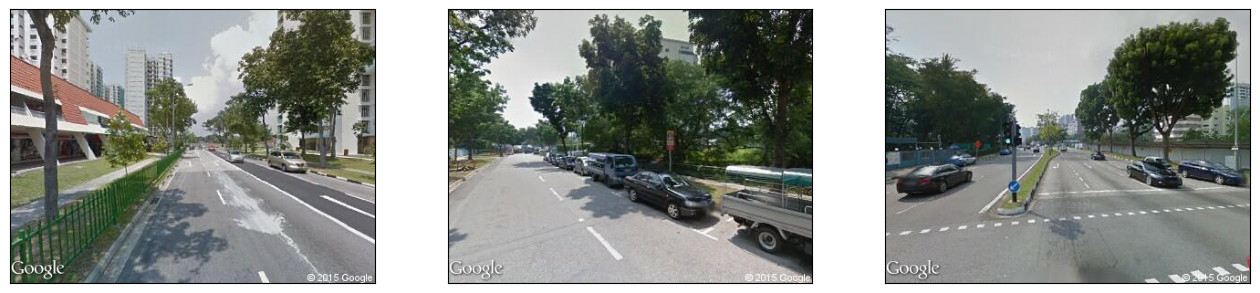

In [43]:
# show sources
from llama_index.core.response.notebook_utils import display_source_node

for text_node in response.metadata["text_nodes"]:
    display_source_node(text_node, source_length=200)
plot_images(
    [n.metadata["file_path"] for n in response.metadata["image_nodes"]]
)

In [44]:
from llama_index.core import PromptTemplate

qa_tmpl_str = (
    "Given the images provided, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)

qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
    llm=mm_model, image_qa_template=qa_tmpl
)

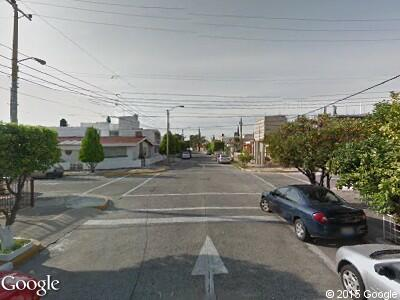

In [46]:
Image.open('20.672456_-103.411312_514135aafdc9f04926004ab6_Guadalajara.JPG')

In [47]:
query_str = "Tell me more about the relationship between those scense."
response = query_engine.image_query("20.672456_-103.411312_514135aafdc9f04926004ab6_Guadalajara.JPG", query_str)

In [54]:
response.response

" The image shows a street scene with various elements. There are vehicles, including cars and trucks, on the road, indicating that traffic is active in this area. Buildings can be seen along the side of the street, suggesting that this might be an urban or suburban setting, possibly within a city or town center. The presence of trees indicates some greenery, which could contribute to a more pleasant environment for residents and visitors alike. The overcast sky suggests that the weather is currently cloudy, which might affect visibility for drivers and pedestrians.\n\nAs for the relationship between these elements, they all coexist in this urban landscape. Cars and trucks on the road are part of daily commuting or transportation needs, while buildings are typically residential or commercial structures that provide housing or services to the community. Trees contribute to the aesthetics of the area and can also offer benefits such as shade and improved air quality. The overcast sky is 

In [56]:
response

Response(response=" The image shows a street scene with various elements. There are vehicles, including cars and trucks, on the road, indicating that traffic is active in this area. Buildings can be seen along the side of the street, suggesting that this might be an urban or suburban setting, possibly within a city or town center. The presence of trees indicates some greenery, which could contribute to a more pleasant environment for residents and visitors alike. The overcast sky suggests that the weather is currently cloudy, which might affect visibility for drivers and pedestrians.\n\nAs for the relationship between these elements, they all coexist in this urban landscape. Cars and trucks on the road are part of daily commuting or transportation needs, while buildings are typically residential or commercial structures that provide housing or services to the community. Trees contribute to the aesthetics of the area and can also offer benefits such as shade and improved air quality. Th

**Node ID:** 5ecbebc0-3e6c-483e-87b8-a01faf690cb8<br>**Similarity:** 0.805685367950094<br>**Text:** <br>**Image:**

**Node ID:** 5923363c-9bf0-4af6-8b2c-8b29822cf727<br>**Similarity:** 0.7974337458245166<br>**Text:** <br>**Image:**

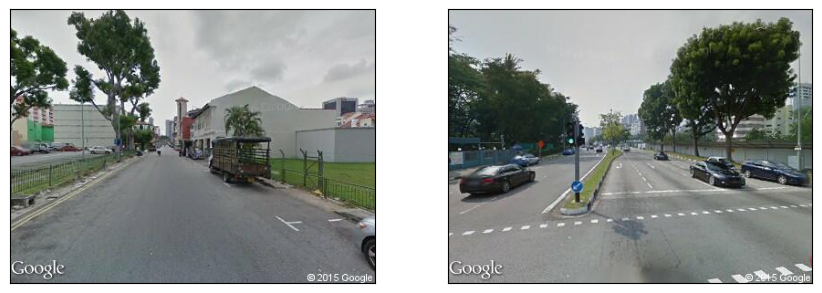

In [49]:
# show sources
from llama_index.core.response.notebook_utils import display_source_node

for text_node in response.metadata["image_nodes"]:
    display_source_node(text_node, source_length=200)
plot_images(
    [n.metadata["file_path"] for n in response.metadata["image_nodes"]]
)

In [ ]:
!wget "https://www.dropbox.com/scl/fi/mlaymdy1ni1ovyeykhhuk/tesla_2021_10k.htm?rlkey=qf9k4zn0ejrbm716j0gg7r802&dl=1" -O tesla_2021_10k.htm
!wget "https://docs.google.com/uc?export=download&id=1THe1qqM61lretr9N3BmINc_NWDvuthYf" -O shanghai.jpg

# from llama_index import SimpleDirectoryReader
from pathlib import Path
from llama_index.readers.file import UnstructuredReader
from llama_index.core.schema import ImageDocument


# loader = UnstructuredReader()
# documents = loader.load_data(file=Path("tesla_2021_10k.htm"))

image_doc = ImageDocument(image_path="1.274615_103.797243_50f561a0fdc9f065f0005614_Singapore.JPG")

In [1]:
from llama_index.core.prompts import PromptTemplate
from llama_index.core.query_pipeline import QueryPipeline, FnComponent

query_prompt_str = """\
Please expand the initial statement using the provided context from the Tesla 10K report.

{initial_statement}

"""
query_prompt_tmpl = PromptTemplate(query_prompt_str)

# MM model --> query prompt --> query engine
qp = QueryPipeline(
    modules={
        "mm_model": mm_model.as_query_component(
            partial={"image_documents": [image_doc]}
        ),
        "query_prompt": query_prompt_tmpl,
        "query_engine": query_engine,
    },
    verbose=True,
)
qp.add_chain(["mm_model", "query_prompt", "query_engine"])
rag_response = qp.run("Which Tesla Factory is shown in the image?")

NameError: name 'mm_model' is not defined